<a href="https://colab.research.google.com/github/thwlruss10/VDA_pipeline/blob/main/StressGraph_22May.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install torch_geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.7 MB/s eta 0:00:00


In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
import time
import networkx as nx
import matplotlib.pyplot as plt
from rl4co.envs import FJSPEnv
from rl4co.models.zoo.l2d import L2DModel
from rl4co.models.zoo.l2d.policy import L2DPolicy
from rl4co.models.zoo.l2d.decoder import L2DDecoder
from rl4co.models.nn.graph.hgnn import HetGNNEncoder
from rl4co.utils.trainer import RL4COTrainer

ModuleNotFoundError: No module named 'rl4co'

In [ ]:
generator_params = {
  "num_jobs": 5,  # the total number of jobs
  "num_machines": 5,  # the total number of machines that can process operations
  "min_ops_per_job": 1,  # minimum number of operatios per job
  "max_ops_per_job": 2,  # maximum number of operations per job
  "min_processing_time": 1,  # the minimum time required for a machine to process an operation
  "max_processing_time": 20,  # the maximum time required for a machine to process an operation
  "min_eligible_ma_per_op": 1,  # the minimum number of machines capable to process an operation
  "max_eligible_ma_per_op": 2,  # the maximum number of machines capable to process an operation
}

In [ ]:
env = FJSPEnv(generator_params=generator_params)
td = env.reset(batch_size=[1])

In [ ]:
# Create a bipartite graph from the adjacency matrix
G = nx.Graph()
proc_times = td["proc_times"].squeeze(0)
job_ops_adj = td["job_ops_adj"].squeeze(0)
order = td["ops_sequence_order"].squeeze(0) + 1

num_machines, num_operations = proc_times.shape
num_jobs = job_ops_adj.size(0)

jobs = [f"j{i+1}" for i in range(num_jobs)]
machines = [f"m{i+1}" for i in range(num_machines)]
operations = [f"o{i+1}" for i in range(num_operations)]

# Add nodes from each set
G.add_nodes_from(machines, bipartite=0)
G.add_nodes_from(operations, bipartite=1)
G.add_nodes_from(jobs, bipartite=2)

# Add edges based on the adjacency matrix
for i in range(num_machines):
    for j in range(num_operations):
        edge_weigth = proc_times[i][j]
        if edge_weigth != 0:
            G.add_edge(f"m{i+1}", f"o{j+1}", weight=edge_weigth)


# Add edges based on the adjacency matrix
for i in range(num_jobs):
    for j in range(num_operations):
        edge_weigth = job_ops_adj[i][j]
        if edge_weigth != 0:
            G.add_edge(f"j{i+1}", f"o{j+1}", weight=3, label=order[j])


widths = [x / 3 for x in nx.get_edge_attributes(G, 'weight').values()]

plt.figure(figsize=(10,6))
# Plot the graph

machines = [n for n, d in G.nodes(data=True) if d['bipartite'] == 0]
operations = [n for n, d in G.nodes(data=True) if d['bipartite'] == 1]
jobs = [n for n, d in G.nodes(data=True) if d['bipartite'] == 2]

pos = {}
pos.update((node, (1, index)) for index, node in enumerate(machines))
pos.update((node, (2, index)) for index, node in enumerate(operations))
pos.update((node, (3, index)) for index, node in enumerate(jobs))

edge_labels = {(u, v): d['label'].item() for u, v, d in G.edges(data=True) if d.get("label") is not None}
nx.draw_networkx_edge_labels(G, {k: (v[0]+.12, v[1]) for k,v in pos.items()}, edge_labels=edge_labels, rotate=False)

nx.draw_networkx_nodes(G, pos, nodelist=machines, node_color='b', label="Machine")
nx.draw_networkx_nodes(G, pos, nodelist=operations, node_color='r', label="Operation")
nx.draw_networkx_nodes(G, pos, nodelist=jobs, node_color='y', label="jobs")
nx.draw_networkx_edges(G, pos, width=widths, alpha=0.6)

plt.title('Visualization of the FJSP')
plt.legend(bbox_to_anchor=(.95, 1.05))
plt.axis('off')
plt.show()

In [3]:
import ortools

ModuleNotFoundError: No module named 'ortools'

In [5]:
pip install ortools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 8.9 MB/s eta 0:00:00
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0


In [8]:
NUM_FRAMES = 10
STAGES = ["Analysis", "Checking", "IFC"]
NUM_ANALYSTS = 3
NUM_CHECKERS = 1  # Checker is a distinct role


In [6]:
from ortools.sat.python import cp_model

model = cp_model.CpModel()


In [9]:
TASK_DURATION = {
    "Analysis": 2,
    "Checking": 1,
    "IFC": 1,
}

tasks = {}  # (frame_id, stage) → Task Info
all_intervals = []  # To collect for NoOverlap

for frame_id in range(NUM_FRAMES):
    for stage in STAGES:
        suffix = f"_f{frame_id}_{stage}"
        duration = TASK_DURATION[stage]
        start = model.NewIntVar(0, 100, "start" + suffix)
        end = model.NewIntVar(0, 100, "end" + suffix)
        interval = model.NewIntervalVar(start, duration, end, "interval" + suffix)
        tasks[(frame_id, stage)] = (start, end, interval)


In [10]:
for frame_id in range(NUM_FRAMES):
    a_start, a_end, _ = tasks[(frame_id, "Analysis")]
    c_start, c_end, _ = tasks[(frame_id, "Checking")]
    i_start, i_end, _ = tasks[(frame_id, "IFC")]

    model.Add(c_start >= a_end)
    model.Add(i_start >= c_end)


In [11]:
analyst_intervals = [[] for _ in range(NUM_ANALYSTS)]

for frame_id in range(NUM_FRAMES):
    a_start, a_end, _ = tasks[(frame_id, "Analysis")]
    duration = TASK_DURATION["Analysis"]
    for analyst_id in range(NUM_ANALYSTS):
        suffix = f"_f{frame_id}_a{analyst_id}"
        assigned = model.NewBoolVar("assigned" + suffix)
        interval = model.NewOptionalIntervalVar(a_start, duration, a_end, assigned, "interval" + suffix)
        analyst_intervals[analyst_id].append(interval)


In [12]:
for intervals in analyst_intervals:
    model.AddNoOverlap(intervals)


In [13]:
checker_intervals = []

for frame_id in range(NUM_FRAMES):
    _, _, c_interval = tasks[(frame_id, "Checking")]
    checker_intervals.append(c_interval)

model.AddNoOverlap(checker_intervals)


In [14]:
# Completion time = latest end among all IFCs
makespan = model.NewIntVar(0, 100, "makespan")
for frame_id in range(NUM_FRAMES):
    _, ifc_end, _ = tasks[(frame_id, "IFC")]
    model.Add(makespan >= ifc_end)

model.Minimize(makespan)


In [15]:
solver = cp_model.CpSolver()
status = solver.Solve(model)

if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    print("Project completes in", solver.Value(makespan), "units")
    for frame_id in range(NUM_FRAMES):
        for stage in STAGES:
            start = solver.Value(tasks[(frame_id, stage)][0])
            end = solver.Value(tasks[(frame_id, stage)][1])
            print(f"Frame {frame_id}, {stage}: {start} → {end}")
else:
    print("No feasible solution found")


Project completes in 13 units
Frame 0, Analysis: 0 → 2
Frame 0, Checking: 6 → 7
Frame 0, IFC: 7 → 8
Frame 1, Analysis: 0 → 2
Frame 1, Checking: 10 → 11
Frame 1, IFC: 11 → 12
Frame 2, Analysis: 0 → 2
Frame 2, Checking: 8 → 9
Frame 2, IFC: 9 → 10
Frame 3, Analysis: 0 → 2
Frame 3, Checking: 7 → 8
Frame 3, IFC: 8 → 9
Frame 4, Analysis: 0 → 2
Frame 4, Checking: 2 → 3
Frame 4, IFC: 3 → 4
Frame 5, Analysis: 0 → 2
Frame 5, Checking: 3 → 4
Frame 5, IFC: 4 → 5
Frame 6, Analysis: 0 → 2
Frame 6, Checking: 11 → 12
Frame 6, IFC: 12 → 13
Frame 7, Analysis: 0 → 2
Frame 7, Checking: 4 → 5
Frame 7, IFC: 5 → 6
Frame 8, Analysis: 0 → 2
Frame 8, Checking: 5 → 6
Frame 8, IFC: 6 → 7
Frame 9, Analysis: 0 → 2
Frame 9, Checking: 9 → 10
Frame 9, IFC: 10 → 11


In [16]:
import networkx as nx
import matplotlib.pyplot as plt


In [17]:
NUM_FRAMES = 10
STAGES = ["Analysis", "Checking", "IFC"]
TASK_DURATION = {"Analysis": 2, "Checking": 1, "IFC": 1}


In [18]:
G = nx.DiGraph()


In [19]:
for frame_id in range(NUM_FRAMES):
    for stage in STAGES:
        task_id = f"F{frame_id}_{stage}"
        G.add_node(task_id,
                   frame=frame_id,
                   stage=stage,
                   duration=TASK_DURATION[stage],
                   roles=["Analyst"] if stage == "Analysis" else (
                       ["Checker"] if stage == "Checking" else ["Engineer"])
                  )


In [20]:
for frame_id in range(NUM_FRAMES):
    G.add_edge(f"F{frame_id}_Analysis", f"F{frame_id}_Checking")
    G.add_edge(f"F{frame_id}_Checking", f"F{frame_id}_IFC")


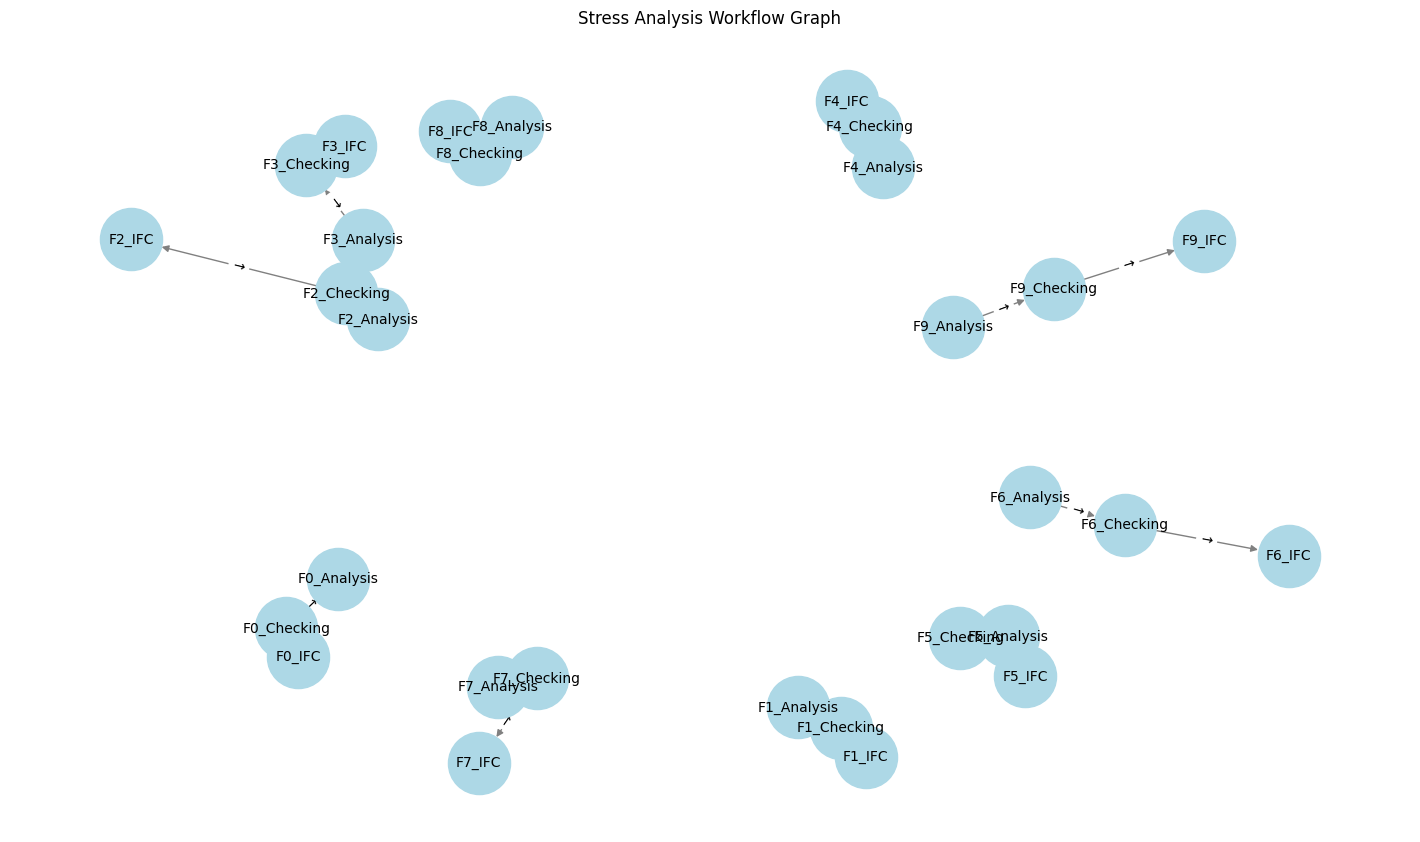

In [25]:
pos = nx.spring_layout(G)
plt.figure(figsize=(14, 8))
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): '→' for u, v in G.edges()})
plt.title("Stress Analysis Workflow Graph")
plt.axis("off")
plt.show()



In [26]:
SKILL_LEVELS = {"Beginner": 1, "Intermediate": 2, "Advanced": 3}
TASK_DIFFICULTY = {"Level 1": 1, "Level 2": 2, "Level 3": 3}


In [27]:
analysts = {
    "A0": {"level": 1},
    "A1": {"level": 2},
    "A2": {"level": 3},  # Advanced
    "Checker": {"level": 3}  # Can also analyze Level 3 tasks
}


In [28]:
frame_difficulties = {
    0: 1, 1: 1, 2: 2, 3: 3, 4: 2, 5: 1, 6: 3, 7: 1, 8: 2, 9: 3
}


In [29]:
for frame_id in range(NUM_FRAMES):
    difficulty = frame_difficulties[frame_id]

    for analyst_id, analyst_info in analysts.items():
        skill_level = analyst_info["level"]

        if skill_level >= difficulty:
            # Create optional interval for this analyst doing this task
            # (just like earlier, but now conditionally created)
            ...


In [31]:
G.nodes["F3_Analysis"]["difficulty"] = 3



In [32]:
eligible_analyst_task_edges = []
for analyst_name, a_data in analysts.items():
    for frame_id, difficulty in frame_difficulties.items():
        if a_data["level"] >= difficulty:
            eligible_analyst_task_edges.append((analyst_name, f"F{frame_id}_Analysis"))


In [33]:
analysts = {
    "A0": {"level": 1},  # Beginner
    "A1": {"level": 2},  # Intermediate
    "A2": {"level": 3},  # Advanced
    "Checker": {"level": 3}
}


In [34]:
import networkx as nx

G = nx.DiGraph()
TASK_STAGES = ["Analysis", "Checking", "IFC"]

# Example difficulty levels per frame (could be randomized or fixed)
frame_difficulty = {
    0: 1, 1: 2, 2: 1, 3: 3, 4: 2, 5: 1, 6: 2, 7: 3, 8: 1, 9: 3
}

for frame_id in range(10):
    for stage in TASK_STAGES:
        node = f"F{frame_id}_{stage}"
        G.add_node(node,
                   frame=frame_id,
                   stage=stage,
                   duration={"Analysis": 2, "Checking": 1, "IFC": 1}[stage],
                   difficulty=frame_difficulty[frame_id] if stage == "Analysis" else None
        )


In [35]:
for frame_id in range(10):
    G.add_edge(f"F{frame_id}_Analysis", f"F{frame_id}_Checking")
    G.add_edge(f"F{frame_id}_Checking", f"F{frame_id}_IFC")


In [36]:
# Add analyst nodes
for analyst, data in analysts.items():
    G.add_node(analyst, type="resource", level=data["level"])

# Create eligibility edges from analyst to analysis tasks
for analyst, data in analysts.items():
    for frame_id, difficulty in frame_difficulty.items():
        if data["level"] >= difficulty:
            G.add_edge(analyst, f"F{frame_id}_Analysis", relation="eligible_for")


In [37]:
paths = []
for frame_id in range(10):
    path = nx.shortest_path(G, source=f"F{frame_id}_Analysis", target=f"F{frame_id}_IFC")
    paths.append(path)


In [38]:
node_colors = []
for node in G.nodes():
    if "Analysis" in node:
        node_colors.append("skyblue")
    elif "Checking" in node:
        node_colors.append("orange")
    elif "IFC" in node:
        node_colors.append("lightgreen")
    elif "A" in node or node == "Checker":
        node_colors.append("gray")

edge_colors = ["black" if G[u][v].get("relation") != "eligible_for" else "purple" for u, v in G.edges()]
